<a href="https://colab.research.google.com/github/Jarvis-BITS/midodrine-mimic-iv/blob/main/notebook/01a_feature_importance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [1]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf 
from sklearn.linear_model import LogisticRegression as lr
from sklearn.ensemble import RandomForestClassifier 
import xgboost as xgb
from  xgboost import XGBClassifier
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

import sys
import requests 
import io
import warnings
warnings.filterwarnings('ignore')

Check to see if GPU connected. 
It is advised to add GPU from Runtime<Change runtime type<Hardware Accelaration<GPU for faster processing speeds

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Importing csv 

In [43]:
table_cohort = pd.read_csv('table_cohort.csv')

In [44]:
table_cohort.describe()

,stay_id,hadm_id,subject_id,age,midodrine,avg_doses_per_24_hrs,los_hospital,los_icu,adm_weekday,weight,...,epi_rate,norepinephrine_use,norepi_rate,phenylephrine_use,phenyl_rate,milrinone_use,mort_28_day,admit_hour,MICU,Gender
count,8.674000e+03,8.674000e+03,8.674000e+03,8674.000000,8674.000000,8674.000000,8674.000000,8674.000000,8674.000000,8498.000000,...,465.000000,6878.0,6878.000000,3864.0,3864.000000,100.0,8674.000000,8674.000000,8674.000000,8674.000000
mean,3.497774e+07,2.502663e+07,1.500673e+07,65.522712,0.098455,1.554209,15.618630,8.015915,3.988241,82.518946,...,0.158489,1.0,0.132138,1.0,1.594022,1.0,0.256975,12.822343,0.628430,0.447890
std,2.896182e+06,2.876491e+06,2.865990e+06,15.851190,0.297946,0.264804,16.022397,8.391177,2.000196,26.824864,...,0.271936,0.0,0.163415,0.0,5.394138,0.0,0.436991,7.462557,0.483252,0.497306
min,3.000048e+07,2.000130e+07,1.000188e+07,18.000000,0.000000,0.806452,1.000000,1.000000,1.000000,1.000000,...,0.010001,1.0,0.010000,1.0,0.020001,1.0,0.000000,0.000000,0.000000,0.000000
25%,3.242515e+07,2.257122e+07,1.255871e+07,56.000000,0.000000,1.373737,6.000000,2.710000,2.000000,65.400000,...,0.040038,1.0,0.058011,1.0,0.657065,1.0,0.000000,6.000000,0.000000,0.000000
50%,3.499144e+07,2.504838e+07,1.501399e+07,67.000000,0.000000,1.525000,11.000000,5.000000,4.000000,78.000000,...,0.075199,1.0,0.096937,1.0,1.036963,1.0,0.000000,15.000000,1.000000,0.000000
75%,3.749099e+07,2.752799e+07,1.746052e+07,77.000000,0.000000,1.700000,20.000000,10.250000,6.000000,95.000000,...,0.136470,1.0,0.166468,1.0,1.984483,1.0,1.000000,19.000000,1.000000,1.000000
max,3.999923e+07,2.999910e+07,1.999984e+07,102.000000,1.000000,4.580000,467.000000,101.750000,7.000000,833.000000,...,2.389600,1.0,6.399658,1.0,298.685819,1.0,1.000000,23.000000,1.000000,1.000000


In [45]:
table_cohort['vaso_starttime'] = pd.to_datetime(table_cohort['vaso_starttime'])
table_cohort['vaso_endtime'] = pd.to_datetime(table_cohort['vaso_endtime'])
table_cohort['icu_intime'] = pd.to_datetime(table_cohort['icu_intime'])
table_cohort['icu_outtime'] = pd.to_datetime(table_cohort['icu_outtime'])

table_cohort['english'] = table_cohort['language'].str.contains('english', case=False).astype(np.int32)
table_cohort.drop(['language'], axis=1, inplace=True)

In [218]:
table_cohort['vaso_duration'] = ((table_cohort['vaso_endtime'] - table_cohort['vaso_starttime']).dt.total_seconds() / 3600) # converting secs to hrs

In [206]:
table_cohort.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8674 entries, 0 to 8673
Data columns (total 85 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   stay_id               8674 non-null   int64         
 1   hadm_id               8674 non-null   int64         
 2   subject_id            8674 non-null   int64         
 3   age                   8674 non-null   int64         
 4   ethnicity             8674 non-null   object        
 5   midodrine             8674 non-null   int64         
 6   avg_doses_per_24_hrs  8674 non-null   float64       
 7   icu_intime            8674 non-null   datetime64[ns]
 8   icu_outtime           8674 non-null   datetime64[ns]
 9   los_hospital          8674 non-null   int64         
 10  los_icu               8674 non-null   float64       
 11  adm_weekday           8674 non-null   int64         
 12  weight                8498 non-null   float64       
 13  sapsii            

In [219]:
mido_data = table_cohort.loc[table_cohort['midodrine'] == 1]
nomido_data = table_cohort.loc[table_cohort['midodrine'] == 0]

## EDA

In [216]:
vaso_start_day_mid = (mido_data['vaso_starttime'] - mido_data['icu_intime']).dt.days
vaso_start_day_nomid = (nomido_data['vaso_starttime'] - nomido_data['icu_intime']).dt.days

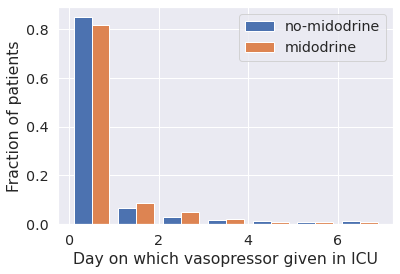

<Figure size 1080x1080 with 0 Axes>

In [217]:
plt.hist([vaso_start_day_nomid, vaso_start_day_mid], bins = [0,1,2,3,4,5,6,7], label=['no-midodrine', 'midodrine'], density=True)
plt.legend(loc='upper right')
plt.xlabel("Day on which vasopressor given in ICU")
plt.ylabel("Fraction of patients")
plt.figure(figsize=(15,15))
plt.show()

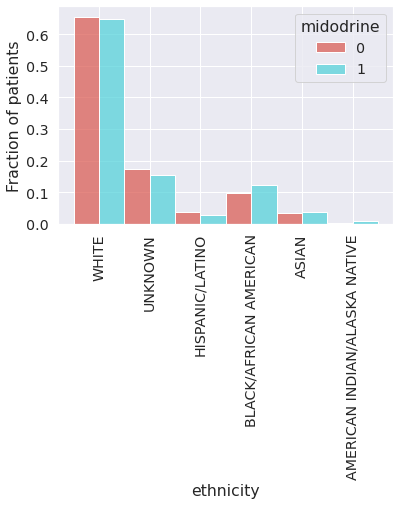

<Figure size 1080x1080 with 0 Axes>

In [94]:
sns.histplot(x = table_cohort['ethnicity'], hue=table_cohort['midodrine'], palette='hls', multiple="dodge", stat = 'density', common_norm=False)
plt.xticks(rotation = 90) 
plt.ylabel("Fraction of patients")
plt.figure(figsize=(15,15))
plt.show()

### Feature importance

In [75]:
X = table_cohort.drop(['subject_id', 'hadm_id', 'stay_id', 'ethnicity', 'mort_28_day', 'midodrine', 'avg_doses_per_24_hrs', 'icu_intime', 'icu_outtime',
                       'los_hospital', 'los_icu', 'vasopressin_use', 'pressin_starttime', 'pressin_endtime',
                       'pressin_rate', 'dobutamine_use', 'dobut_starttime', 'dobut_endtime',
                       'dobut_rate', 'dopamine_use', 'dopa_starttime', 'dopa_endtime',
                       'dopa_rate', 'epinephrine_use', 'epi_starttime', 'epi_endtime',
                       'epi_rate', 'norepinephrine_use', 'norepi_starttime', 'norepi_endtime',
                       'norepi_rate', 'phenylephrine_use', 'phenyl_starttime',
                       'phenyl_endtime', 'phenyl_rate', 'milrinone_use', 'vaso_starttime',
                       'vaso_endtime'], axis=1)

y = table_cohort['midodrine']

In [76]:
seed = 20220614 #for reproducible results
test_size=0.2 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [77]:
#instantiate model and train
model = XGBClassifier(learning_rate = 0.05, n_estimators=300, max_depth=5)
model.fit(X_train, y_train)

XGBClassifier(learning_rate=0.05, max_depth=5, n_estimators=300)

In [78]:
# make predictions for test set
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.10%


In [79]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    model = XGBClassifier(n_estimators=300, learning_rate=learning_rate, max_features=2, max_depth=5, random_state=seed)
    model.fit(X_train, y_train)

    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(model.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(model.score(X_test, y_test)))

Learning rate:  0.05
Accuracy score (training): 0.983
Accuracy score (validation): 0.921
Learning rate:  0.075
Accuracy score (training): 0.993
Accuracy score (validation): 0.920
Learning rate:  0.1
Accuracy score (training): 0.999
Accuracy score (validation): 0.922
Learning rate:  0.25
Accuracy score (training): 1.000
Accuracy score (validation): 0.920
Learning rate:  0.5
Accuracy score (training): 1.000
Accuracy score (validation): 0.924
Learning rate:  0.75
Accuracy score (training): 1.000
Accuracy score (validation): 0.918
Learning rate:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.919


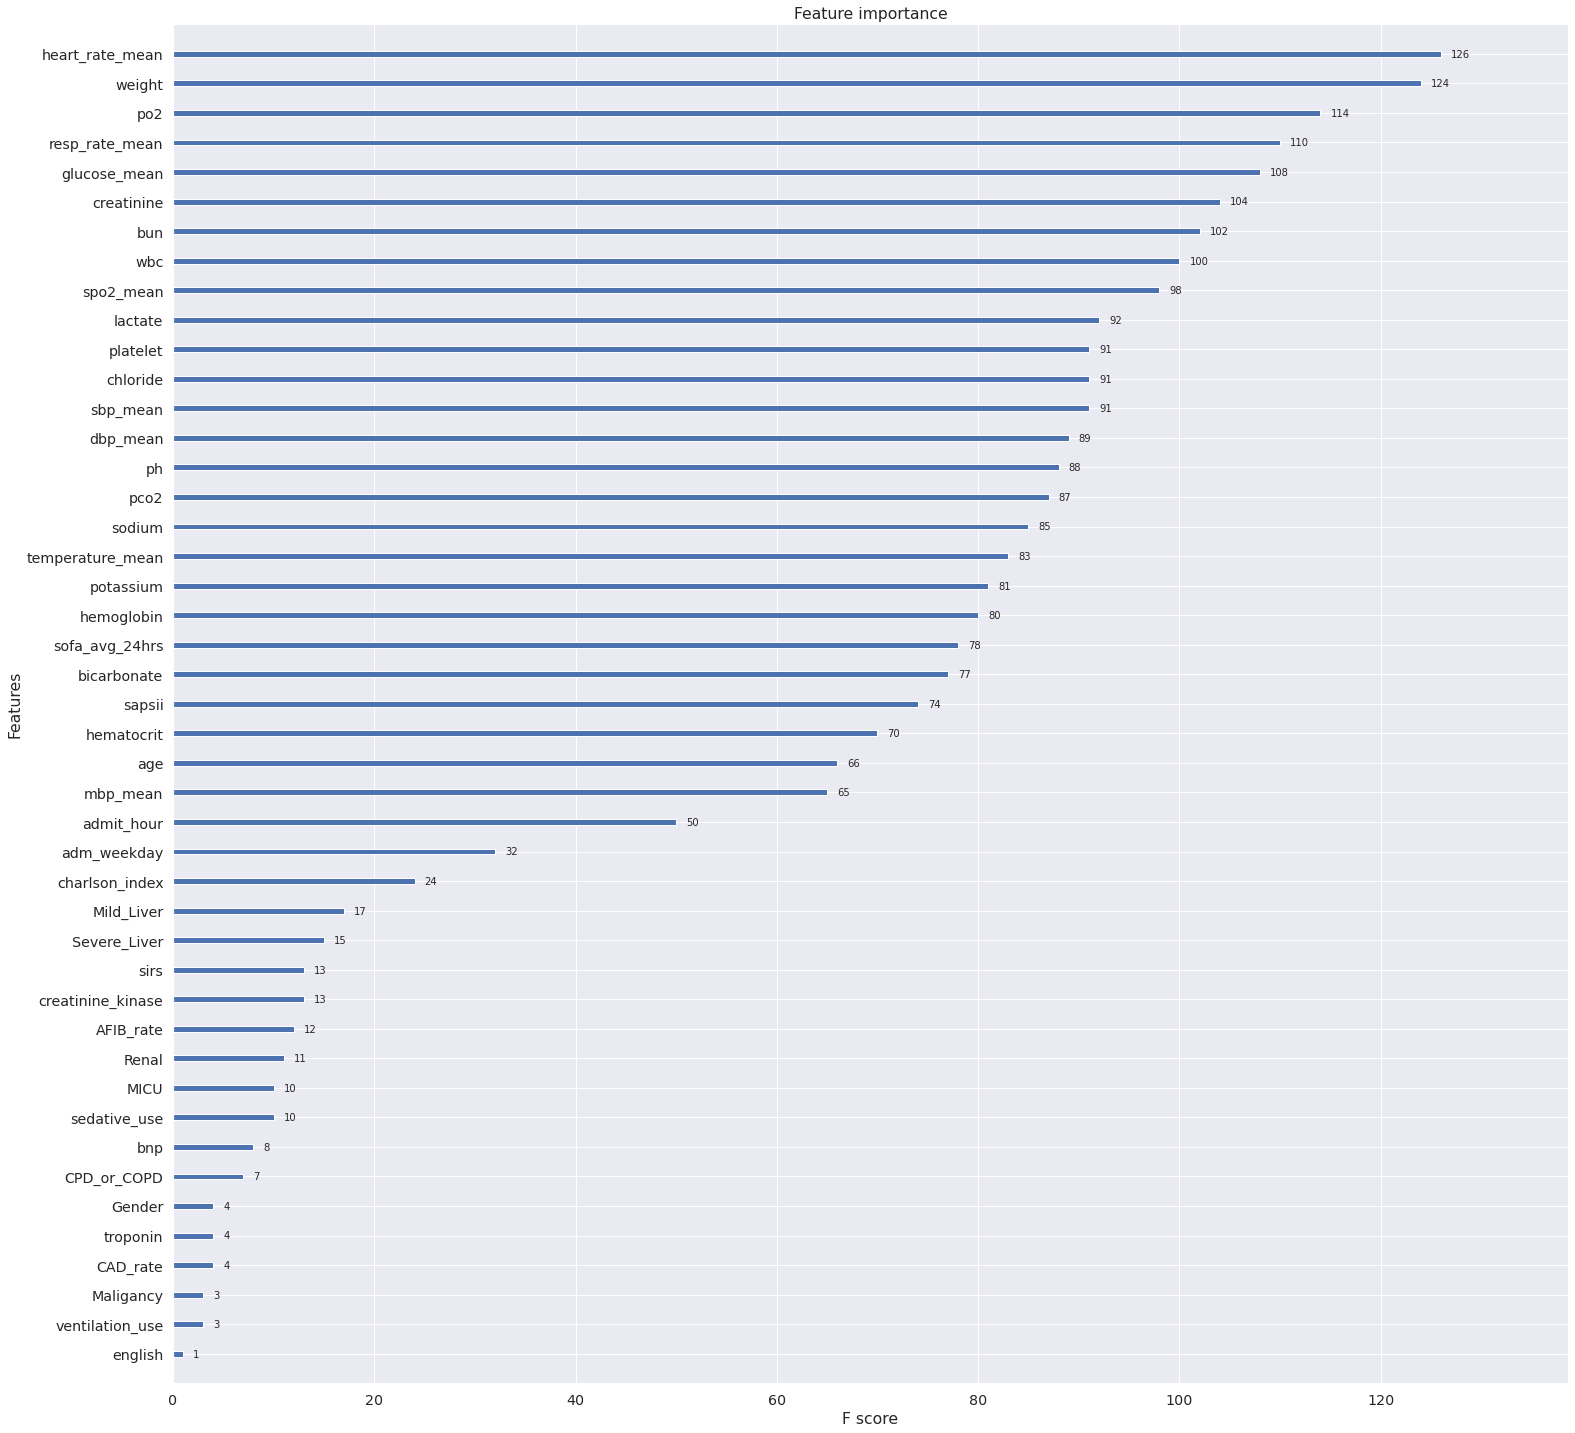

In [82]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# plot feature importance
fig, ax = plt.subplots(figsize=(25,25))
plot_importance(model, ax=ax)
plt.show()